In [1]:
import pandas as pd
df = pd.read_parquet("./data.parquet", engine="fastparquet")
df.head(10)

,spec,variant,comb,real.tests,real.downs,real.solutions,limit.tests,limit.downs,limit.solutions,approx.tests,approx.downs,approx.solutions
0,8170138442655511235,8170138442655511235,16526201983175431742,10,6,2,10,6,2,10,6,2
1,8170138442655511235,8170138442655511235,244911303771612964,10,5,1,10,6,2,10,6,2
2,8170138442655511235,8170138442655511235,18012007887162854874,18,8,2,18,10,4,18,10,4
3,8170138442655511235,8170138442655511235,18336227962480351343,18,8,2,18,10,4,18,10,4
4,8170138442655511235,8170138442655511235,14208887303862700513,20,12,4,20,12,4,20,12,4
5,8170138442655511235,8170138442655511235,11386679209945676179,20,10,2,20,12,4,20,12,4
6,8170138442655511235,8170138442655511235,18199061831065217691,36,16,4,36,20,8,36,20,8
7,8170138442655511235,8170138442655511235,7146135788097632456,36,16,4,36,20,8,36,20,8
8,8170138442655511235,9623179583721650529,16526201983175431742,10,6,2,10,6,2,10,6,2
9,8170138442655511235,9623179583721650529,18012007887162854874,14,6,2,14,8,4,14,8,4


In [2]:
maximums = df.groupby(["variant"]).max().loc[:, "real.tests":].add_prefix("max.")
maximums.head(10)

,max.real.tests,max.real.downs,max.real.solutions,max.limit.tests,max.limit.downs,max.limit.solutions,max.approx.tests,max.approx.downs,max.approx.solutions
variant,,,,,,,,,
2041748704361,1972,748,256,1972,1004,512,1972,1004,512
92987424871602,1972,748,256,1972,1004,512,1972,1004,512
264055068815372,261,137,51,840,567,288,333,169,59
342266733936296,399,261,129,570,381,192,278,156,64
364126309680506,2388,852,256,3924,2004,1024,3924,2004,1024
465211329655293,300,151,52,840,567,288,318,152,47
679176771730428,192,88,25,849,570,288,272,127,37
769974320826633,645,265,51,1254,849,432,780,392,133
929984120815155,1972,748,256,1972,1004,512,1972,1004,512


In [3]:
squished = pd.read_parquet("./squished.parquet", engine="fastparquet").set_index("variant").add_suffix(".squished")
squished = squished.loc[:, "limit.tests.squished":]
squished.head(10)

,limit.tests.squished,limit.downs.squished,limit.solutions.squished,approx.tests.squished,approx.downs.squished,approx.solutions.squished
variant,,,,,,
8170138442655511235,44,28,16,44,24,12
9623179583721650529,48,28,16,40,22,12
193375514051786942,44,28,16,44,24,12
7113731437991570677,48,28,16,40,22,12
8920499427662422113,39,21,12,39,21,12
12836583669089022279,39,21,12,39,21,12
8795361401317431479,100,60,32,100,52,24
9906368122554358752,108,60,32,92,48,24
9987209423702502192,180,116,64,180,100,48


In [4]:
out = maximums.join(squished, on="variant").sort_values("max.real.tests")
out

,max.real.tests,max.real.downs,max.real.solutions,max.limit.tests,max.limit.downs,max.limit.solutions,max.approx.tests,max.approx.downs,max.approx.solutions,limit.tests.squished,limit.downs.squished,limit.solutions.squished,approx.tests.squished,approx.downs.squished,approx.solutions.squished
variant,,,,,,,,,,,,,,,
8635935114419384932,20,12,8,20,12,8,20,12,8,20,12,8,20,12,8
8256365201965896038,20,12,8,20,12,8,20,12,8,20,12,8,20,12,8
7143064551711877105,24,14,7,30,21,12,24,13,6,30,21,12,24,13,6
8575968047569984187,24,14,7,30,21,12,24,13,6,30,21,12,24,13,6
12836583669089022279,26,10,4,26,14,8,26,14,8,39,21,12,39,21,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3785818025899372557,3412,1108,256,7508,3924,2048,7508,3924,2048,7508,3924,2048,7508,3924,2048
1624967645909347984,3412,1108,256,7508,3924,2048,7508,3924,2048,7508,3924,2048,7508,3924,2048
12321316587808635386,3412,1108,256,7508,3924,2048,7508,3924,2048,7508,3924,2048,7508,3924,2048


In [5]:
s = pd.Series(list(range(len(out))))
out = out.set_index(s)
out

,max.real.tests,max.real.downs,max.real.solutions,max.limit.tests,max.limit.downs,max.limit.solutions,max.approx.tests,max.approx.downs,max.approx.solutions,limit.tests.squished,limit.downs.squished,limit.solutions.squished,approx.tests.squished,approx.downs.squished,approx.solutions.squished
0,20,12,8,20,12,8,20,12,8,20,12,8,20,12,8
1,20,12,8,20,12,8,20,12,8,20,12,8,20,12,8
2,24,14,7,30,21,12,24,13,6,30,21,12,24,13,6
3,24,14,7,30,21,12,24,13,6,30,21,12,24,13,6
4,26,10,4,26,14,8,26,14,8,39,21,12,39,21,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256065,3412,1108,256,7508,3924,2048,7508,3924,2048,7508,3924,2048,7508,3924,2048
256066,3412,1108,256,7508,3924,2048,7508,3924,2048,7508,3924,2048,7508,3924,2048
256067,3412,1108,256,7508,3924,2048,7508,3924,2048,7508,3924,2048,7508,3924,2048
256068,3412,1108,256,7508,3924,2048,7508,3924,2048,7508,3924,2048,7508,3924,2048


<AxesSubplot:>

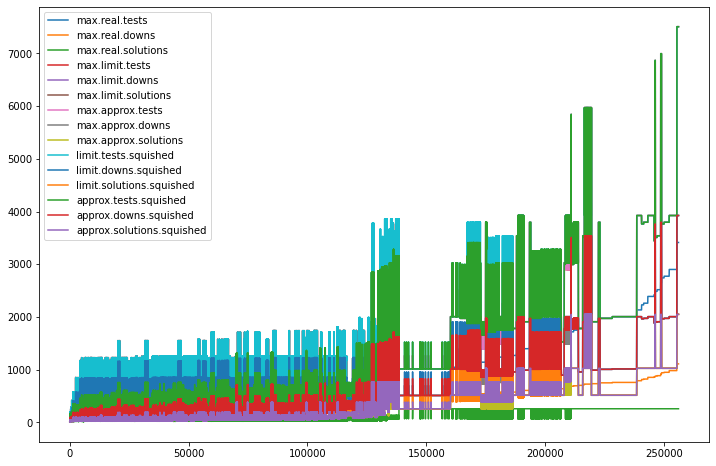

In [6]:
out.plot(figsize=(12,8))

<AxesSubplot:>

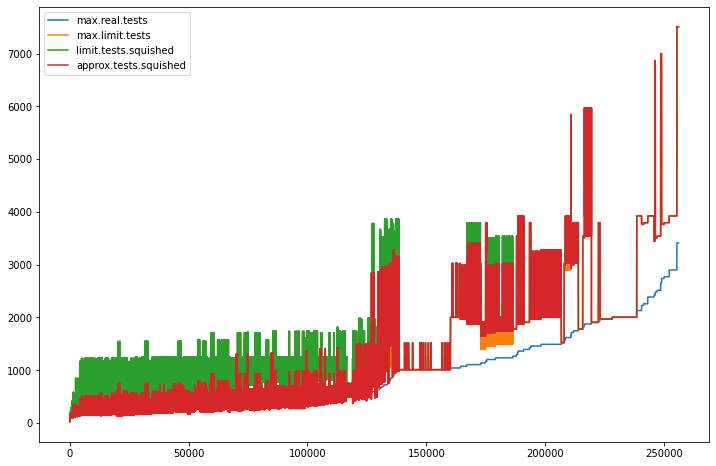

In [7]:
out.loc[:, ["max.real.tests", "max.limit.tests", "limit.tests.squished", "approx.tests.squished"]]\
    .plot(figsize=(12,8))

<AxesSubplot:>

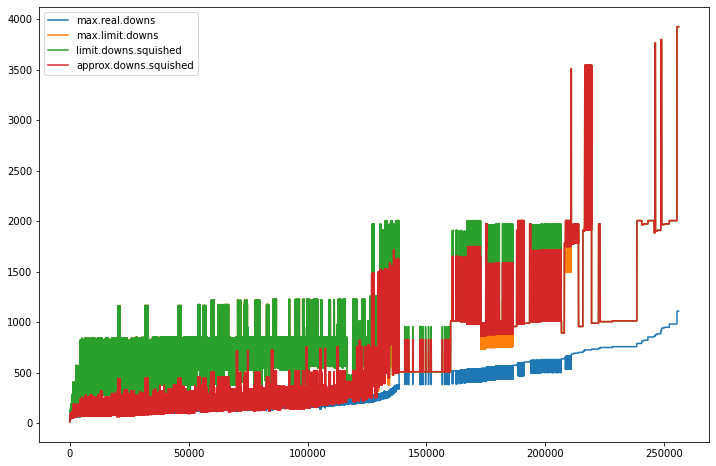

In [8]:
out.loc[:, ["max.real.downs", "max.limit.downs", "limit.downs.squished", "approx.downs.squished"]]\
    .plot(figsize=(12,8))


<AxesSubplot:>

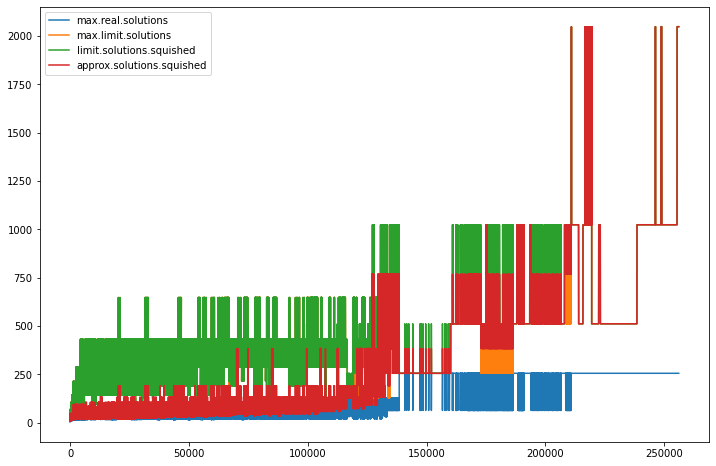

In [9]:
out.loc[:, ["max.real.solutions", "max.limit.solutions", "limit.solutions.squished", "approx.solutions.squished"]]\
    .plot(figsize=(12,8))


<AxesSubplot:>

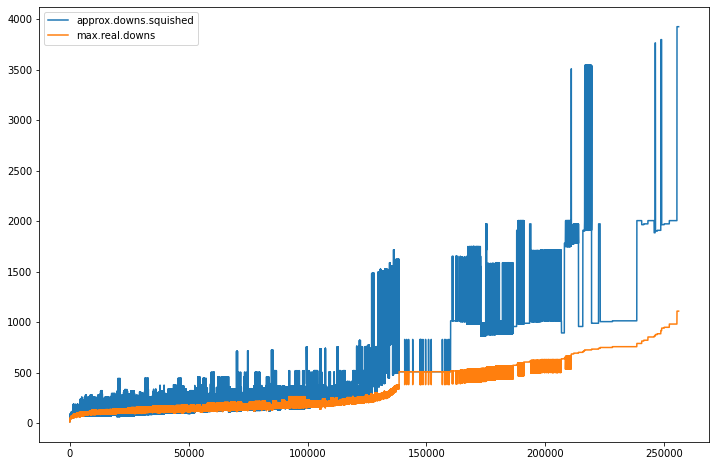

In [26]:
(out.loc[:, ["approx.downs.squished", "max.real.downs"]]).plot(figsize=(12,8))

In [11]:
opti = pd.read_parquet("./optimized.parquet", engine="fastparquet").loc[:, ["spec", "variant", "real.tests", "real.downs"]].groupby("spec").max()
opti

,variant,real.tests,real.downs
spec,,,
238585137062310498,238585137062310498,500,252
341268513264695926,341268513264695926,1012,508
600547193489587490,600547193489587490,244,124
723560145817997963,9721209779290016127,249,123
848625680469529277,13008181402379675262,276,100
...,...,...,...
17882347984246045791,17882347984246045791,244,124
18021964398189097347,18021964398189097347,1012,508
18313325857475709813,2288810833453129256,243,123


In [12]:
d = df.loc[:, ["spec", "variant", "real.tests", "real.downs"]].groupby("variant").max()
d

,spec,real.tests,real.downs
variant,,,
2041748704361,16124395478646635793,1972,748
92987424871602,13733209066831196203,1972,748
264055068815372,5048482347362185639,261,137
342266733936296,14332120870647821853,399,261
364126309680506,341268513264695926,2388,852
...,...,...,...
18446511236712496043,16659108544424059705,1460,620
18446573076515855002,18345951055569818802,201,103
18446598579010004038,10290317636439961218,465,235


In [13]:
d = d.groupby("spec").agg(["min", "max", "mean"]).sort_values(("real.tests", "mean"))
d

real.tests                    real.downs        \
                            min   max         mean        min   max   
spec                                                                  
8256365201965896038          20    20    20.000000         12    12   
3540525455734865730          27    27    27.000000         17    17   
8170138442655511235          26    36    30.000000         10    16   
8575968047569984187          24    39    30.000000         14    19   
14268846526309514646         52    52    52.000000         28    28   
...                         ...   ...          ...        ...   ...   
6489204830653790784        1012  2900  1860.457143        508   980   
341268513264695926         1012  2900  1881.790476        508   980   
1480270534935852502        1012  3412  1885.447619        508  1108   
12989361304717694218       1012  3412  1906.780952        508  1108   
1959445157631805398        1012  3412  2080.800000        508  1108   

                                  
                            mean  
spec                              
8256365201965896038    12.000000  
3540525455734865730    17.000000  
8170138442655511235    12.666667  
8575968047569984187    16.000000  
14268846526309514646   28.000000  
...                          ...  
6489204830653790784   720.114286  
341268513264695926    725.447619  
1480270534935852502   726.361905  
12989361304717694218  731.695238  
1959445157631805398   775.200000  

[100 rows x 6 columns]

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

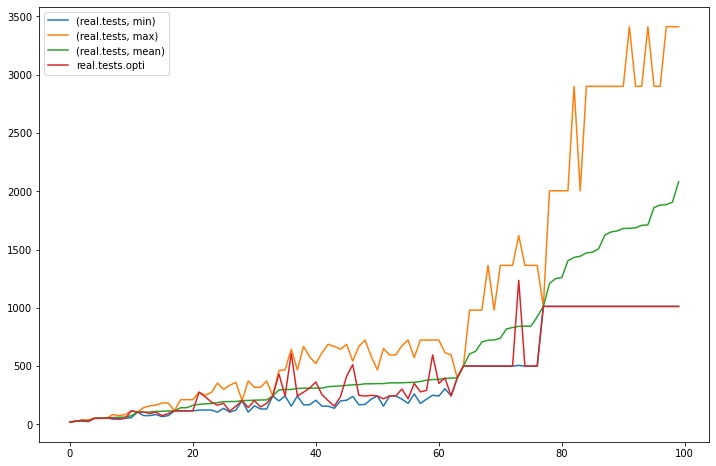

In [14]:
d = d.loc[:, ["real.tests"]].join(opti.loc[:, ["real.tests"]].add_suffix(".opti"), on="spec")
s = pd.Series(list(range(len(d))))
d = d.set_index(s)
d.plot(figsize=(12,8))

In [21]:
import dask.dataframe as dd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [22]:
dir = "./data/tree/precedence/"
real = dd.read_parquet(dir+"data.parquet", columns=["spec","variant","real.tests", "real.downs"])
squished = dd.read_parquet(dir+"squished.parquet", columns=["spec","variant","limit.tests", "limit.downs"])
opti = dd.read_parquet(dir+"optimized.parquet", index=["spec"],columns=["variant","comb", "real.tests", "real.downs"])
squished = squished.groupby(["spec", "variant"]).max()

real_max = real.groupby(["spec", "variant"]).max()

In [23]:
comparison_squished = real_max.join(squished, on=["spec", "variant"]).compute()
comparison_squished = comparison_squished.sort_values("spec")

<AxesSubplot:xlabel='spec'>

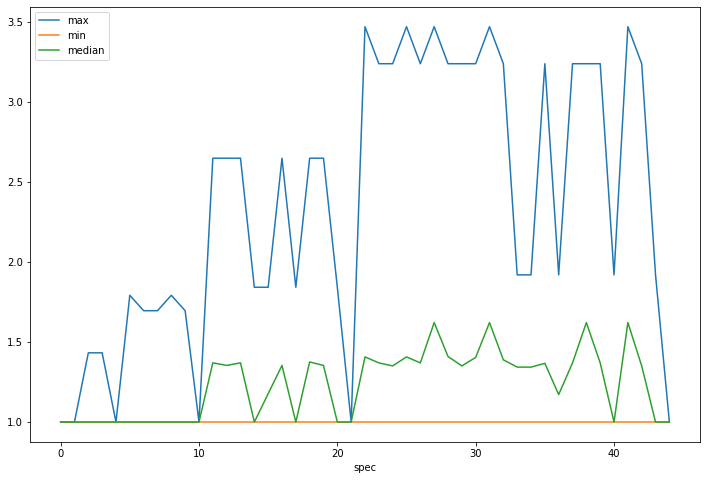

In [31]:
(comparison_squished["limit.tests"]/comparison_squished["real.tests"]).groupby("spec").agg(["max", "min", "median"]).plot(figsize=(12,8))

<AxesSubplot:xlabel='spec,variant'>

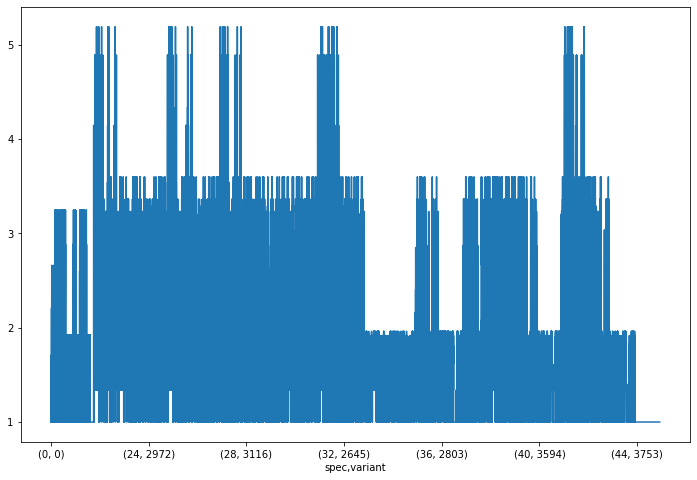

In [25]:
(comparison_squished["limit.downs"]/comparison_squished["real.downs"]).plot(figsize=(12,8))

In [26]:
opti_max = opti.groupby("spec").max()
real_statistics = real_max.groupby("spec").aggregate(["min", "max", "mean"])
compare = real_statistics.join(opti_max)
comparison = compare.compute()

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='spec'>

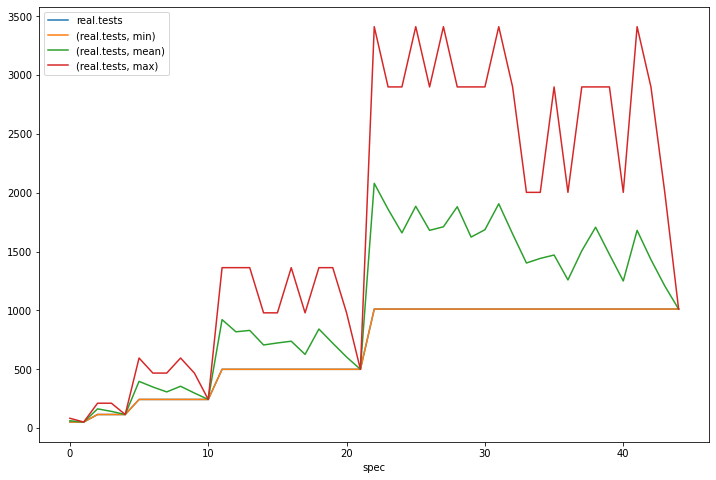

In [27]:
comparison[["real.tests", ("real.tests", "min"), ("real.tests", "mean"), ("real.tests", "max")]].plot(figsize=(12, 8))

In [28]:
comparison[comparison["real.tests"] >= comparison[("real.tests", "mean")]]


,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)",variant,comb,real.tests,real.downs
spec,,,,,,,,,,
1,52,52,52.0,28,28,28.0,0,7,52,28
4,116,116,116.0,60,60,60.0,0,15,116,60
10,244,244,244.0,124,124,124.0,0,31,244,124
21,500,500,500.0,252,252,252.0,0,63,500,252
44,1012,1012,1012.0,508,508,508.0,0,127,1012,508


In [29]:
comparison.count()

(real.tests, min)     45
(real.tests, max)     45
(real.tests, mean)    45
(real.downs, min)     45
(real.downs, max)     45
(real.downs, mean)    45
variant               45
comb                  45
real.tests            45
real.downs            45
dtype: int64